In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['captcha', 'captcha-version-2-images']


In [2]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

Using TensorFlow backend.


In [3]:
print(num_symbols)

36


In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
def preprocess_data():
    n_samples = len(os.listdir('../input/captcha-version-2-images/samples/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('../input/captcha-version-2-images/samples/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('../input/captcha-version-2-images/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [6]:
model=create_model();
model.summary();

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 100, 32)  4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [7]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Train on 776 samples, validate on 194 samples
Epoch 1/30
776/776 [==============================] - 7s 9ms/step - loss: 17.0640 - dense_2_loss: 3.3502 - dense_4_loss: 3.4213 - dense_6_loss: 3.3716 - dense_8_loss: 3.4564 - dense_10_loss: 3.4645 - dense_2_acc: 0.0593 - dense_4_acc: 0.0644 - dense_6_acc: 0.0593 - dense_8_acc: 0.0412 - dense_10_acc: 0.0490 - val_loss: 15.7995 - val_dense_2_loss: 3.0979 - val_dense_4_loss: 3.1229 - val_dense_6_loss: 3.1096 - val_dense_8_loss: 3.2335 - val_dense_10_loss: 3.2355 - val_dense_2_acc: 0.0825 - val_dense_4_acc: 0.0258 - val_dense_6_acc: 0.0773 - val_dense_8_acc: 0.1031 - val_dense_10_acc: 0.0412
Epoch 2/30
776/776 [==============================] - 5s 7ms/step - loss: 15.9102 - dense_2_loss: 3.0968 - dense_4_loss: 3.1381 - dense_6_loss: 3.1254 - dense_8_loss: 3.2613 - dense_10_loss: 3.2885 - dense_2_acc: 0.0902 - dense_4_acc: 0.0644 - dense_6_acc: 0.0928 - dense_8_acc: 0.0722 - dense_10_acc: 0.0528 - val_loss: 15.9648 - val_dense_2_loss: 3.0757 - 

In [8]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [9]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

100/100 [==============================] - 0s 2ms/step
Test Loss and accuracy: [3.2490440234541893, 0.031261714494612534, 0.6204438988794573, 0.9614849987812341, 1.118792209327221, 0.5170612221956253, 0.99, 0.89, 0.75, 0.81, 0.87]


In [10]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('../input/captcha-version-2-images/samples/samples/8n5p3.png'))
print(predict('../input/captcha-version-2-images/samples/samples/f2m8n.png'))
print(predict('../input/captcha-version-2-images/samples/samples/dce8y.png'))
print(predict('../input/captcha-version-2-images/samples/samples/3eny7.png'))
print(predict('../input/captcha-version-2-images/samples/samples/npxb7.png'))

100/100 [==============================] - 0s 2ms/step
8n5p3
f2n8n
dce8y
3eny7
npxb7


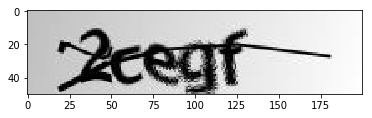

In [11]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('../input/captcha/capthaimage/capthaimages/a.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [23]:
#Lets Predict By Model
print("Predicted Captcha =",predict('../input/captcha/capthaimage/capthaimages/a.png'))

Predicted Captcha = 2cegf


In [13]:
#testing
#c=0
#for i, pic in enumerate(os.listdir('../input/captcha-version-2-images/samples/samples')):
        # Read image as grayscale
        
        #if i>970:    

            #img = cv2.imread(os.path.join('../input/captcha-version-2-images/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
            #print("Predicted Captcha =",predict(os.path.join('../input/captcha-version-2-images/samples/samples',pic)))
            #plt.imshow(img, cmap=plt.get_cmap('gray'))
            #pr=predict(os.path.join('../input/captcha-version-2-images/samples/samples',pic))
            #pic_target = pic[:-4]
            #if pr==pic_target:
                #c=c+1
                #print(c)
            #print(pic_target)
#print((c/100)*100)